Note: If you are using the Google Colab and want to use tensorflow < 2: you will have to downgrade using this link. https://colab.research.google.com/notebooks/tensorflow_version.ipynb

# **Models and their accuracies:**



1.   Using LSTM  => 0.89 
2.   Using Bidirectional LSTM  => 0.89
3.   Less parameters model (8962 parameters) => 0.86





# Sentiment Analysis on IMDB Movie Review dataset

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. We will be using LSTMs and Bi-directional LSTMs to predict two classes - positive or negative sentiment.


You will be reading the dataset from here: https://drive.google.com/file/d/127PCwycL0oToSF6l-c2oFuBkacYsmlgK/view?usp=sharing

You can use this blog for understanding: https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e

In [0]:
%tensorflow_version 1.x
import numpy as np 
import pandas as pd 
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Conv1D, Dropout, Bidirectional, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk 
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/My Drive/DL 6'

/content/drive/My Drive/DL 6


All the relevant libraries are imported. 
You are free to change as you please. 
Using the GPU backend is recommended as LSTMs are computationally expensive to train.



## Data handling - exploration and cleaning





1.   You are expected to read the dataset into a dataframe.
2.   This is a real world dataset and you will be expected to clean the dataset.

1.   This includes removing trailing spaces and HTML tags.






In [33]:
df = pd.read_csv('IMDB Dataset.csv')
df = df.reindex(np.random.permutation(df.index))
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
34050,"The Film must have been shot in a day,there ar...",negative
17682,This movie feels like a film project. As thoug...,positive
32547,I have no idea how anyone managed to stay awak...,negative
8074,Just a great soundtrack. Really enjoyable musi...,positive
6686,Easily 9 out of 10 for a film by director we w...,positive


### Data Cleaning - write the techniques you employed and the achieved results

In [0]:
# WRITE CODE HERE
# Sample code:
df['review'] = df['review'].str.replace('<[^>]+>', '')

In [0]:
df.review = df.review.str.lower()

In [0]:
df["review"] = df['review'].str.replace("[^ a-z0-9]+",' ') 

In [0]:
df['review'] = df['review'].str.strip()
df['sentiment'] = df['sentiment'].str.strip()

In [0]:
allwords = " ".join(df['review'].values.tolist()).split()

In [39]:
allwords[:10]

['the', 'film', 'must', 'have', 'been', 'shot', 'in', 'a', 'day', 'there']

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [0]:
def remove_stopwords(input_text):
    stopwords_list = nltk.corpus.stopwords.words('english')
    whitelist = ["don't", "not", "no",]
    words = input_text.split() 
    lemm = [lemmatizer.lemmatize(w) for w in words]
    clean_words = [word for word in lemm if (word not in stopwords_list or word in whitelist) and len(word) > 2] 
    return " ".join(clean_words)

In [0]:
df.review = df.review.apply(remove_stopwords)

Write about the techniques used to clean:

**I used the following techniques to clean the data:**


1.   Removed html tags. Anything between < > was removed altogether.
2.   All the reviews were converted into lowercase.
3.   Everything that was not a lower case alphabet or a number was replaced by a space.
4.   Both the review and sentiments were stripped of any leading or trailing spaces.
5.   All stopwords were removed except words like don't, not, no which might indicate sentiment.
6.   Lemmatizers were used where they group together the inflected forms of a word so they can be analyzed as a single item. 







### Data Exploration



1.   You are required to report the total number of distinct tokens present in the data set.
2.   Find out the minimum and max length of a review.

An integral part of visualization when it comes to textual data is the generating of a word cloud.

1.   
This task is open-ended and you can use any library of your choice. 
NLTK is one such library. 
2.   
Make sure to keep note of stop words.

##Example:


![alt text](https://getthematic.com/wp-content/uploads/2018/03/Harris-Word-Cloud-e1522406279125.png)




In [0]:
allwords = " ".join(df['review'].values.tolist()).split(" ")

In [0]:
result = len(set(allwords))

In [46]:
print('Total number of Distinct Tokens Present:' )
result

Total number of Distinct Tokens Present:


93006

In [47]:
print('Maximum Length of a Review:' )
df.review.map(len).max()

Maximum Length of a Review:


9048

In [48]:
print('Minimum Length of a Review:' )
df.review.map(len).min()

Minimum Length of a Review:


17

In [0]:
from wordcloud import WordCloud

In [0]:
wordcloud = WordCloud().generate(''.join(df.review.astype(str).tolist()))

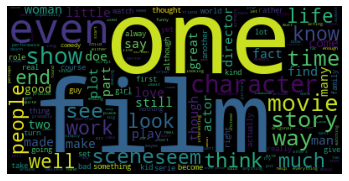

In [51]:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Model processing

You can use a 70:30 train/test split.
The labels are 'positive' and negative, you should assign them integers 0 or 1 for further processing.

In [0]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['sentiment']]).toarray())


# le = LabelEncoder()

# df['labels'] = le.fit_transform(df.sentiment.values)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df.review, enc_df, test_size=0.3, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 35000
# Test data samples: 15000


In [0]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

### Tokenizer
You will need to use fit a tokenizer over your training and testing data.

What does a tokenizer do?
It creates a dictionary of word to integer mappings. It updates internal vocabulary based on a list of texts. You should read up on the documentation before diving into the code. 

You will also be using the the text_to_sequence function will return integers based on a respective tokenizer.

Make sure you **pad** your sequences to max length using sequence.pad_sequences()




In [0]:
# WRITE CODE HERE
tk = Tokenizer(num_words=93006,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [216]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    35000.000000
mean       117.910457
std         88.428900
min          3.000000
25%         63.000000
50%         88.000000
75%        143.000000
max       1162.000000
Name: review, dtype: float64

In [0]:
X_train_seq_trunc = sequence.pad_sequences(X_train_seq, maxlen=1162)
X_test_seq_trunc = sequence.pad_sequences(X_test_seq, maxlen=1162)

In [214]:
X_train_seq_trunc.shape

(35000, 1162)

### Embedding layer
You will be importing the embedding layer from Keras.
Embedding layers are common place when handling textual data. 
Word embeddings provide a dense representation of words and their relative meanings.

#### How do they work - via Stack Overflow
Link: https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

The output vectors are not computed from the input using any mathematical operation. Instead, each input integer is used as the index to access a table that contains all posible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).

The most common application of this layer is for text processing. Let's see a simple example. Our training set consists only of two phrases:

Hope to see you soon

Nice to see you again

So we can encode these phrases by assigning each word a unique integer number (by order of appearance in our training dataset for example). Then our phrases could be rewritten as:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Now imagine we want to train a network whose first layer is an embeding layer. In this case, we should initialize it as follows:

Embedding(7, 2, input_length=5)

The first argument (7) is the number of distinct words in the training set. The second argument (2) indicates the size of the embedding vectors. The input_length argumet, of course, determines the size of each input sequence.

Once the network has been trained, we can get the weights of the embedding layer, which in this case will be of size (7, 2) and can be thought as the table used to map integers to embedding vectors.


### Model Engineering

You will be required to engineer three types of models from scratch.

1.   Using LSTMs
2.   Bi-directional LSTMs

1.   A model with less than 10,000 parameters - the lower the parameters, higher the score (provided accuracy is good)


For each model:

1.   You will be reporting graphs for validation accuracy and training loss.
2.   What hyper-parameters, loss functions, optimizations, initializations were used. This should be clearly stated in your analysis.

~90 percent and above is the desired accuracy. 

For model 3, CLEARLY report the number of parameters.




Model 1

In [0]:
input_dim = result #result = 93006
output_dim = 80
epochs = 5
#Optimizer = Adam
#Loss function = Categorical Cross entropy
#LSTM units = 200
#Dropout rate = 0.2

In [67]:
# CODE HERE

# Some example code to help you get started
# X_train is your training data 
# input_dim is your dictionary length, output_dim is the length is the dimension of the dense embedding, you can choose whatever works best for you, starting with 2.
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', save_best_only=True, monitor='val_accuracy', mode='max')
model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length = X_train_seq_trunc.shape[1]))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss ='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.name ='Using LSTMS'
print(model.summary())
# You can choose to complete this model per your choice

Model: "Using LSTMS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1162, 80)          7440480   
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               224800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 7,665,682
Trainable params: 7,665,682
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
batch_size = 512
hist = model.fit(X_train_seq_trunc, 
          y_train, 
          epochs = epochs, 
          batch_size=batch_size, 
          validation_data = (X_test_seq_trunc, y_test),
          use_multiprocessing = True,
          callbacks = [checkpoint],
          workers = 200)

Train on 35000 samples, validate on 15000 samples
Epoch 1/5
35000/35000 [==============================] - 151s 4ms/step - loss: 0.6101 - accuracy: 0.6952 - val_loss: 0.4977 - val_accuracy: 0.7730
Epoch 2/5
35000/35000 [==============================] - 151s 4ms/step - loss: 0.2840 - accuracy: 0.8858 - val_loss: 0.3142 - val_accuracy: 0.8838
Epoch 3/5
35000/35000 [==============================] - 151s 4ms/step - loss: 0.1474 - accuracy: 0.9479 - val_loss: 0.3020 - val_accuracy: 0.8864
Epoch 4/5
35000/35000 [==============================] - 151s 4ms/step - loss: 0.0866 - accuracy: 0.9727 - val_loss: 0.3397 - val_accuracy: 0.8791
Epoch 5/5
35000/35000 [==============================] - 150s 4ms/step - loss: 0.0520 - accuracy: 0.9856 - val_loss: 0.4329 - val_accuracy: 0.8760


The best accuracy is 0.8864 => 0.89 and the weights at that epoch are saved.


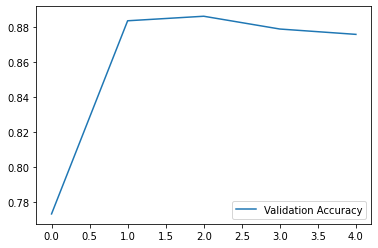

In [71]:
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

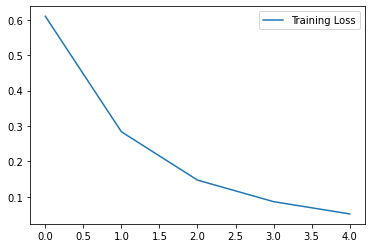

In [70]:
plt.plot(hist.history['loss'],label='Training Loss')
plt.legend()

**ANALYSIS**


The validation accuracy starts to decrease after the 3rd epoch as the model overfits despite dropout. Training loss decreases with each epoch and training accuracy increases. The loss function used is categorical cross entropy since there is only one sentiment for each review. The optimizer used is Adam. The hyperparameters of the model are written under the model heading.

Model 2

In [0]:
input_dim = result #result = 93006
output_dim = 80
epochs = 5
#Optimizer = Adam
#Loss function = Categorical Cross entropy
#LSTM units = 200
#Dropout rate = 0.5

In [73]:
input_dim = result
output_dim = 80
# Some example code to help you get started
# X_train is your training data 
# input_dim is your dictionary length, output_dim is the length is the dimension of the dense embedding, you can choose whatever works best for you, starting with 2.
checkpoint = ModelCheckpoint('model1-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', save_best_only=True, monitor='val_accuracy', mode='max')
model1 = Sequential()
model1.add(Embedding(input_dim, output_dim, input_length = X_train_seq_trunc.shape[1]))
model1.add(Bidirectional (LSTM (200,dropout=0.50)))
model1.add(Dense(2,activation='softmax'))

model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model1.name ='Using Bidirectional LSTMS'
print(model1.summary())

Model: "Using Bidirectional LSTMS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1162, 80)          7440480   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               449600    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 802       
Total params: 7,890,882
Trainable params: 7,890,882
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
batch_size = 512
hist2 = model1.fit(X_train_seq_trunc, 
          y_train, 
          epochs = 5, 
          batch_size=batch_size, 
          validation_data = (X_test_seq_trunc, y_test),
          use_multiprocessing = True,
          callbacks = [checkpoint],
          workers = 200)

Train on 35000 samples, validate on 15000 samples
Epoch 1/5
35000/35000 [==============================] - 276s 8ms/step - loss: 0.5197 - accuracy: 0.7611 - val_loss: 0.3220 - val_accuracy: 0.8642
Epoch 2/5
35000/35000 [==============================] - 275s 8ms/step - loss: 0.2395 - accuracy: 0.9056 - val_loss: 0.3056 - val_accuracy: 0.8883
Epoch 3/5
35000/35000 [==============================] - 275s 8ms/step - loss: 0.1571 - accuracy: 0.9428 - val_loss: 0.2875 - val_accuracy: 0.8883
Epoch 4/5
35000/35000 [==============================] - 276s 8ms/step - loss: 0.1120 - accuracy: 0.9612 - val_loss: 0.3178 - val_accuracy: 0.8837
Epoch 5/5
35000/35000 [==============================] - 276s 8ms/step - loss: 0.0787 - accuracy: 0.9733 - val_loss: 0.3580 - val_accuracy: 0.8768


The best accuracy is 0.8883 => 0.89 and the weights at that epoch are saved.

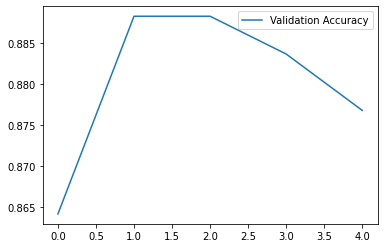

In [77]:
plt.plot(hist2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

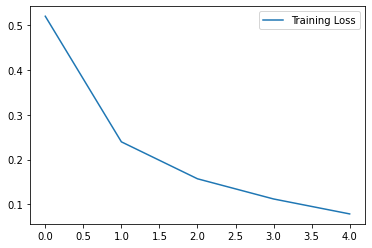

In [78]:
plt.plot(hist2.history['loss'],label='Training Loss')
plt.legend()

**ANALYSIS**

The validation accuracy starts to decrease after the 3rd epoch as the model overfits despite a dropout of 0.50. Training loss decreases with each epoch and the training accuracy increases. The loss function used is categorical cross entropy since there is only one sentiment for each review. The optimizer used is Adam.  The hyperparameters of the model are written under the model heading.

Model 3

In [0]:
# WRITE CODE HERE
tk = Tokenizer(num_words=1000,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [189]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    35000.000000
mean       117.910457
std         88.428900
min          3.000000
25%         63.000000
50%         88.000000
75%        143.000000
max       1162.000000
Name: review, dtype: float64

In [0]:
X_train_seq_trunc = sequence.pad_sequences(X_train_seq, maxlen=1000)
X_test_seq_trunc = sequence.pad_sequences(X_test_seq, maxlen=1000)

In [0]:
input_dim = 1000
output_dim = 2
epochs = 20
#Optimizer = Adam
#Loss function = Categorical Cross entropy
#LSTM units = 40
#Dropout rate = 0.2

In [196]:
# Some example code to help you get started
# X_train is your training data 
# input_dim is your dictionary length, output_dim is the length is the dimension of the dense embedding, you can choose whatever works best for you, starting with 2.

model2 = Sequential()
model2.add(Embedding(input_dim, output_dim, input_length = X_train_seq_trunc.shape[1]))
model2.add(LSTM (40,dropout=0.50))
model2.add(Dense(2,activation='softmax'))
model2.name ='Less Parameters'
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


print(model2.summary())

Model: "Less Parameters"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 1000, 2)           2000      
_________________________________________________________________
lstm_22 (LSTM)               (None, 40)                6880      
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 82        
Total params: 8,962
Trainable params: 8,962
Non-trainable params: 0
_________________________________________________________________
None


In [197]:
batch_size = 512
hist1 = model2.fit(X_train_seq_trunc, 
          y_train, 
          epochs = 20, 
          batch_size=batch_size, 
          validation_data = (X_test_seq_trunc, y_test),
          use_multiprocessing = True,
          callbacks = [checkpoint],
          workers = 100)

Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 92s 3ms/step - loss: 0.6765 - accuracy: 0.5939 - val_loss: 0.5787 - val_accuracy: 0.7311
Epoch 2/20
35000/35000 [==============================] - 88s 3ms/step - loss: 0.5206 - accuracy: 0.7251 - val_loss: 0.3955 - val_accuracy: 0.8251
Epoch 3/20
35000/35000 [==============================] - 90s 3ms/step - loss: 0.4529 - accuracy: 0.7561 - val_loss: 0.3692 - val_accuracy: 0.8404
Epoch 4/20
35000/35000 [==============================] - 88s 3ms/step - loss: 0.4305 - accuracy: 0.7674 - val_loss: 0.3595 - val_accuracy: 0.8462
Epoch 5/20
35000/35000 [==============================] - 87s 2ms/step - loss: 0.4177 - accuracy: 0.7711 - val_loss: 0.3378 - val_accuracy: 0.8558
Epoch 6/20
35000/35000 [==============================] - 87s 2ms/step - loss: 0.4336 - accuracy: 0.7664 - val_loss: 0.3665 - val_accuracy: 0.8326
Epoch 7/20
35000/35000 [==============================] - 87s 2ms/st

The best accuracy is 0.8598 => 0.86 and the weights at that epoch are saved.

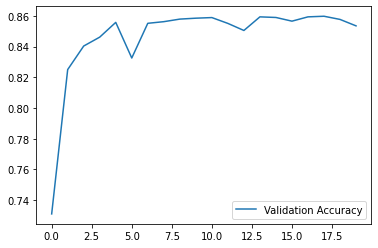

In [200]:
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

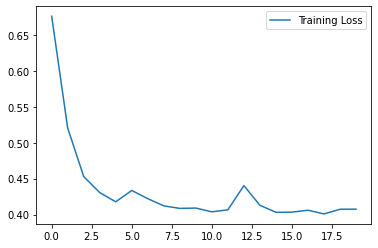

In [199]:
plt.plot(hist1.history['loss'],label='Training Loss')
plt.legend()

**ANALYSIS**

The validation accuracy increases initially and then oscillates. Training loss sharply decreases initially with each epoch and then oscillates. The loss function used is categorical cross entropy since there is only one sentiment for each review. The optimizer used is Adam.  The hyperparameters of the model are written under the model heading.

### Model Predictions. For your best performing model

Come up with ten sample sentences NOT part of the original data set. 
Use model.predict() to generate predictions and report positive or negative sentiment.

In [0]:
a = "This movie was pretty bad."
b = "What a stupid film!!!"
c = "I loved it. The acting was great."
d = "Such an inspiring movie. "
e = "How pathetic is this movie. Boring!"
f = "I wasted my time."
g = "Loved it. Will definitely watch again!"
h = "I really like it."
i = "They need to come up with something new. Was average."
j = "Really a wonderful movie. Loved the plot."

In [202]:
Samples = [a,b,c,d,e,f,g,h,i,j]
Samples

['This movie was pretty bad.',
 'What a stupid film!!!',
 'I loved it. The acting was great.',
 'Such an inspiring movie. ',
 'How pathetic is this movie. Boring!',
 'I wasted my time.',
 'Loved it. Will definitely watch again!',
 'I really like it.',
 'They need to come up with something new. Was average.',
 'Really a wonderful movie. Loved the plot.']

In [0]:
sample_seq = tk.texts_to_sequences(Samples)

In [0]:
sample_seq_trunc = sequence.pad_sequences(sample_seq, maxlen=1162)

In [205]:
sample_seq_trunc.shape

(10, 1162)

In [0]:
model1.load_weights('model1-002-0.905629-0.888267.h5')
y_pred = model1.predict(sample_seq_trunc) #best performing model is the second model!!!
y_pred = np.array([np.argmax(pred) for pred in y_pred])

In [220]:
y_pred #1 is positive sentiment, 0 is negative sentiment

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1])

In [0]:
#Actual should be 0 0 1 1 0 0 1 1 0 1